Autoencoder (non supervisé) sur THCA / PTC

Question : peut-on discriminer des sous-types moléculaires
           sans label a priori à partir de l'expression ?

In [45]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import umap 

import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers, callbacks, Model
from sklearn.cluster import SpectralClustering
from scipy.stats import chi2_contingency


In [46]:
# Paramètres de directions
OUTDIR = "../results_autoencoder"
os.makedirs(OUTDIR, exist_ok=True)

RANDOM_SEED = 555
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
 
# Paramètres Autoencoder
LATENT_DIM = 16
EPOCHS = 200
BATCH_SIZE = 32
LR = 1e-3

# Clustering
K_MIN, K_MAX = 2, 8  # on teste plusieurs k

# Sélection de gènes 
TOP_VAR_GENES = 500  # mets None pour désactiver

# 1. **Charger les données**

In [47]:
df = pd.read_csv("../data/THCA_expression_matrix_final.csv", index_col= 0)
print("CSV chargé :", df.shape)
print("Colonnes (extrait):", df.columns[:10].tolist(), "...")

df.head()

CSV chargé : (60660, 475)
Colonnes (extrait): ['ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC', 'ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC', 'ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC', 'ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC', 'ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC', 'ID=TCGA-EL-A3T7_AGE=47ANS_SEX=female_STAGE=Stade_II_MUT=BRAF_TYPE=PTC', 'ID=TCGA-FE-A230_AGE=30ANS_SEX=female_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC', 'ID=TCGA-EM-A3FO_AGE=40ANS_SEX=male_STAGE=Stade_I_MUT=BRAF_TYPE=PTC', 'ID=TCGA-DJ-A3VB_AGE=52ANS_SEX=male_STAGE=Stade_III_MUT=BRAF_TYPE=PTC', 'ID=TCGA-BJ-A28X_AGE=32ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC'] ...


,ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3T7_AGE=47ANS_SEX=female_STAGE=Stade_II_MUT=BRAF_TYPE=PTC,ID=TCGA-FE-A230_AGE=30ANS_SEX=female_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC,ID=TCGA-EM-A3FO_AGE=40ANS_SEX=male_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A3VB_AGE=52ANS_SEX=male_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,ID=TCGA-BJ-A28X_AGE=32ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,...,ID=TCGA-DJ-A13S_AGE=19ANS_SEX=female_STAGE=Stade_I_MUT=RAS_TYPE=PTC,ID=TCGA-EM-A3SY_AGE=36ANS_SEX=male_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EM-A2P1_AGE=33ANS_SEX=male_STAGE=Stage_NA_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3T1_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A2PS_AGE=40ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-EL-A3TB_AGE=47ANS_SEX=female_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-BJ-A45C_AGE=78ANS_SEX=male_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-DJ-A3UX_AGE=46ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,ID=TCGA-DJ-A2PX_AGE=54ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,ID=TCGA-EL-A3ZS_AGE=22ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC
ENSG00000000003.15,6156,7191,2219,5185,4466,9702,2449,6336,5997,3534,...,2448,3693,2691,4533,4471,4742,3753,4488,6131,4097
ENSG00000000005.6,7,3,1,0,3,0,0,0,2,1,...,0,0,0,0,0,3,4,5,6,4
ENSG00000000419.13,2540,3815,735,2594,1496,2506,811,1892,3074,1769,...,1851,2286,2227,2406,1832,2172,1491,2061,2439,2218
ENSG00000000457.14,1452,767,305,970,820,1036,619,725,856,948,...,764,459,759,1120,922,1171,962,1151,1213,829
ENSG00000000460.17,297,276,28,135,208,315,194,149,317,332,...,176,185,279,381,226,245,166,250,242,313


# 2. **Preprocessing**

## *Filtrage HVG*

In [48]:
df = df.copy().T

variances = df.var(axis=0)
top_genes = variances.sort_values(ascending=False).head(TOP_VAR_GENES).index
X_hvg = df[top_genes]
X_hvg


,ENSG00000042832.12,ENSG00000115414.21,ENSG00000198804.2,ENSG00000198886.2,ENSG00000210082.2,ENSG00000198938.2,ENSG00000211592.8,ENSG00000211896.7,ENSG00000164733.22,ENSG00000120885.22,...,ENSG00000100097.12,ENSG00000118705.17,ENSG00000127948.16,ENSG00000074410.14,ENSG00000136352.19,ENSG00000042493.16,ENSG00000091136.15,ENSG00000143761.16,ENSG00000229807.12,ENSG00000172757.13
ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,2131062,1722652,891163,524661,494913,364170,88333,70179,1036001,1235363,...,23057,34124,11707,3519,22521,30672,48826,37887,16843,32656
ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,2150009,622736,291615,150668,134770,131377,10476,14425,871157,935110,...,13627,47577,18499,409,16467,37862,17858,42388,6409,35270
ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,2485163,90318,189345,166924,195922,168881,6872,5079,441622,874656,...,16826,18230,10713,701,8757,24705,6178,24426,12,40839
ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,4231112,6043,253610,170294,134838,128580,4352,14883,161881,146319,...,984,30723,20025,3184,11881,10845,14693,33476,7917,20617
ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,874404,991447,267877,175456,106100,109789,5576,6682,290929,276835,...,9498,17389,8248,1492,9095,13290,18217,20748,13861,17347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID=TCGA-EL-A3TB_AGE=47ANS_SEX=female_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,2084062,181019,397220,283778,182703,228389,39394,51259,812444,765561,...,19218,40762,17419,21722,20945,27693,29638,33827,1385,32480
ID=TCGA-BJ-A45C_AGE=78ANS_SEX=male_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,3683187,5605,616970,386679,245896,226680,88,84,305124,289803,...,2647,9994,11515,6161,22818,15153,11032,28873,1,16931
ID=TCGA-DJ-A3UX_AGE=46ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,2993363,324850,772270,510406,314334,491447,129739,214328,610522,701500,...,4193,29395,13826,3908,14507,16925,12653,32482,21187,23659
ID=TCGA-DJ-A2PX_AGE=54ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,2877400,154139,776891,477236,281066,317812,897905,924718,563147,558456,...,10254,35195,15123,5295,19629,15567,25281,30366,10125,33227


## *Normalisation*

In [49]:
# log1p
X_log = pd.DataFrame(np.log1p(X_hvg.values), index = X_hvg.index, columns = X_hvg.columns)
X_log

,ENSG00000042832.12,ENSG00000115414.21,ENSG00000198804.2,ENSG00000198886.2,ENSG00000210082.2,ENSG00000198938.2,ENSG00000211592.8,ENSG00000211896.7,ENSG00000164733.22,ENSG00000120885.22,...,ENSG00000100097.12,ENSG00000118705.17,ENSG00000127948.16,ENSG00000074410.14,ENSG00000136352.19,ENSG00000042493.16,ENSG00000091136.15,ENSG00000143761.16,ENSG00000229807.12,ENSG00000172757.13
ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,14.572131,14.359376,13.700284,13.170510,13.112139,12.805379,11.388880,11.158819,13.850880,14.026876,...,10.045768,10.437786,9.368028,8.166216,10.022248,10.331138,10.796039,10.542390,9.731750,10.393815
ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,14.580983,13.341880,12.583193,11.922841,11.811332,11.785834,9.256938,9.576787,13.677579,13.748421,...,9.519882,10.770126,9.825526,6.016157,9.709174,10.541730,9.790263,10.654644,8.765615,10.470816
ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Stade_III_MUT=BRAF_TYPE=PTC,14.725849,11.411103,12.151331,12.025300,12.185477,12.036956,8.835356,8.533067,12.998212,13.681587,...,9.730740,9.810879,9.279307,6.553933,9.077723,10.114801,8.728912,10.103444,2.564949,10.617417
ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Stage_NA_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,15.257976,8.706821,12.443557,12.045288,11.811837,11.764314,8.378621,9.608042,11.994623,11.893551,...,6.892642,10.332799,9.904787,8.066208,9.382780,9.291552,9.595195,10.418614,8.976894,9.933920
ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,13.681299,13.806922,12.498287,12.075149,11.572147,11.606325,8.626406,8.807322,12.580838,12.531181,...,9.158942,9.763651,9.017847,7.308543,9.115590,9.494842,9.810165,9.940253,9.536907,9.761233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID=TCGA-EL-A3TB_AGE=47ANS_SEX=female_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,14.549830,12.106363,12.892248,12.555951,12.115623,12.338810,10.581394,10.844666,13.607803,13.548365,...,9.863655,10.615530,9.765374,9.986127,9.949703,10.228971,10.296846,10.429044,7.234177,10.388411
ID=TCGA-BJ-A45C_AGE=78ANS_SEX=male_STAGE=Stade_III_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,15.119289,8.631593,13.332577,12.865353,12.412668,12.331299,4.488636,4.442651,12.628477,12.576960,...,7.881560,9.209840,9.351493,8.726157,10.035349,9.626020,9.308646,10.270697,0.693147,9.736961
ID=TCGA-DJ-A3UX_AGE=46ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC,14.911908,12.691122,13.557091,13.142964,12.658215,13.105111,11.773288,12.275267,13.322071,13.460978,...,8.341410,10.288614,9.534378,8.271037,9.582456,9.736606,9.445729,10.388472,9.961190,10.071541
ID=TCGA-DJ-A2PX_AGE=54ANS_SEX=female_STAGE=Stade_I_MUT=NO_CANONICAL_DRIVER_TYPE=PTC,14.872398,11.945617,13.563057,13.075769,12.546348,12.669218,13.707821,13.737245,13.241298,13.232933,...,9.235521,10.468688,9.624038,8.574707,9.884814,9.652973,10.137848,10.321112,9.222862,10.411148


## *Scaling*

In [50]:
# Split non supervisé : on garde une val pour early stopping (pas de labels)
X_train, X_val = train_test_split(X_log, test_size=0.2, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_all_sc = scaler.transform(X_log)

print("Preprocess OK. Train:", X_train_sc.shape, "Val:", X_val_sc.shape)

Preprocess OK. Train: (380, 500) Val: (95, 500)


# 3. **Autoencodeur**

## *Modèle*

In [51]:
input_dim = X_train_sc.shape[1]
inputs = layers.Input(shape=(input_dim,), name="input")

# Encoder
x = layers.Dense(256, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4),
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4),
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)
x = layers.Dropout(0.2)(x)
latent = layers.Dense(LATENT_DIM, activation=None, name="latent",
                      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)

# Decoder
x = layers.Dense(64, activation="relu",
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(latent)
x = layers.Dense(256, activation="relu",
                 kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)
outputs = layers.Dense(input_dim, activation=None, name="recon",
                       kernel_initializer=tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED))(x)

autoencoder = Model(inputs, outputs, name="autoencoder")
encoder = Model(inputs, latent, name="encoder")

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="mse"
)

autoencoder.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

hist = autoencoder.fit(
    X_train_sc, X_train_sc,
    validation_data=(X_val_sc, X_val_sc),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ recon (Dense)                   │ (None, 500)            │       128,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,972 (1.11 MB)

 Trainable params: 291,972 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0227 - val_loss: 0.9736
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8109 - val_loss: 0.7291
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6656 - val_loss: 0.6116
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5985 - val_loss: 0.5606
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5572 - val_loss: 0.5426
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5345 - val_loss: 0.5127
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5246 - val_loss: 0.4993
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4943 - val_loss: 0.4835
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4716 - val_loss: 0.4545
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4551 - val_loss: 0.4470
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4503 - val_loss: 0.4438
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

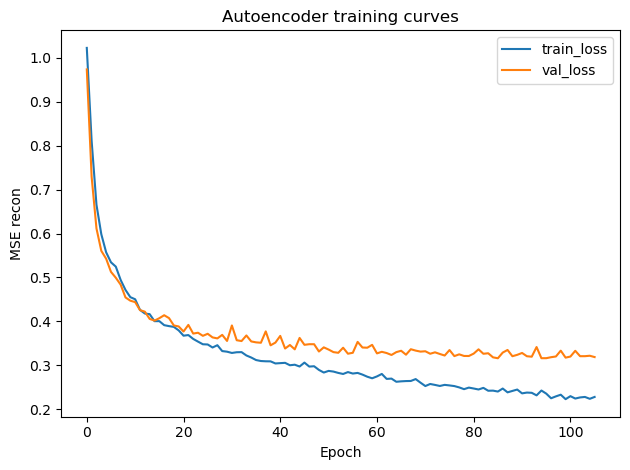

In [52]:
# Courbes loss
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE recon")
plt.title("Autoencoder training curves")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "autoencoder_loss_curves.pdf"), dpi=200)
plt.show()

## *Extraction de l'espace latent pour tous les échantillons*

In [53]:
Z = encoder.predict(X_all_sc, batch_size=256, verbose=0)
print("Latent embedding Z:", Z.shape)

# Extract sample IDs from column names
sample_ids = X_hvg.index.tolist()  # X was transposed, so index contains sample IDs
id_col = "sample_id"

latent_df = pd.DataFrame(Z, columns=[f"z{i+1}" for i in range(Z.shape[1])])
latent_df.insert(0, id_col, sample_ids)
latent_path = os.path.join(OUTDIR, "latent_embedding.csv")
latent_df.to_csv(latent_path, index=False)
print("Saved:", latent_path)

Latent embedding Z: (475, 16)
Saved: ../results_autoencoder/latent_embedding.csv


# **4. Clustering**

## *Choix du nombre de clusters*

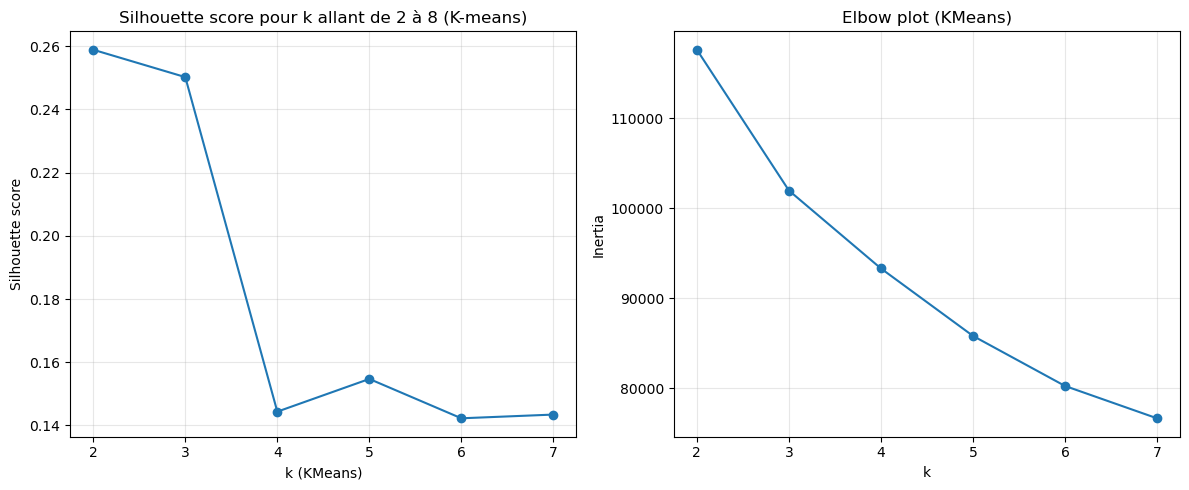

In [54]:
Ks = range(K_MIN, K_MAX)
sil_scores = []

for k in Ks:
    labels = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20).fit_predict(Z)
    sil_scores.append(silhouette_score(Z, labels))

# elbow plot
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
    km.fit(Z)
    inertias.append(km.inertia_)
    
# plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Ks, sil_scores, marker="o")
plt.xlabel("k (KMeans)")
plt.ylabel("Silhouette score")
plt.title(f"Silhouette score pour k allant de {K_MIN} à {K_MAX} (K-means)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(Ks, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow plot (KMeans)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "k_selection_silhouette.pdf"), dpi=200)
plt.show()

In [55]:
# meilleur k et son silhouette score associé
best_k = 2
best_sil = silhouette_score(Z, KMeans(n_clusters=best_k, random_state=RANDOM_SEED, n_init=20).fit_predict(Z))

## *Clustering Spectral*

In [56]:
spectral = SpectralClustering(
    n_clusters=best_k,
    affinity="nearest_neighbors",
    assign_labels="kmeans",
    random_state=RANDOM_SEED)

cluster_labels = spectral.fit_predict(Z)


# 5. **Visualisation 2D**

## *UMAP*

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_40502/2401930467.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20b', n_clusters)


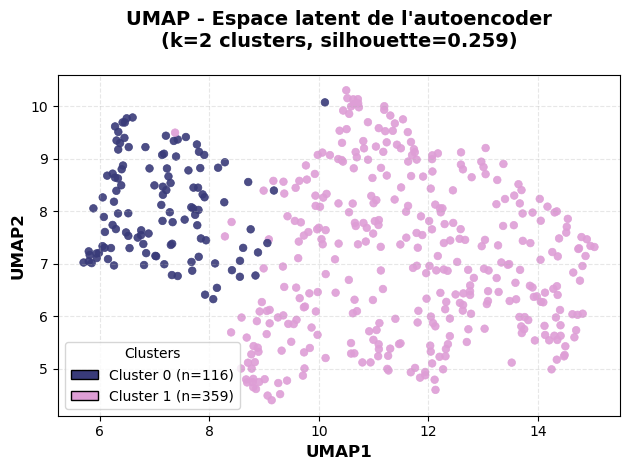

In [57]:
reducer = umap.UMAP(n_neighbors=13, min_dist=0.2, random_state=RANDOM_SEED,n_jobs=1)
emb2d = reducer.fit_transform(Z)
method = "UMAP"

# Créer une palette de couleurs pour les clusters
from matplotlib import cm
import matplotlib.patches as mpatches

n_clusters = len(np.unique(cluster_labels))
colors = cm.get_cmap('tab20b', n_clusters)

plt.figure()
scatter = plt.scatter(
    emb2d[:, 0], 
    emb2d[:, 1], 
    c=cluster_labels, 
    cmap='tab20b',
    s=30, 
    alpha=0.9,
    linewidth=0.5
)

# Ajouter la légende des clusters
legend_elements = [
    mpatches.Patch(
        facecolor=colors(i), 
        edgecolor='black',
        label=f'Cluster {i} (n={np.sum(cluster_labels == i)})'
    )
    for i in range(n_clusters)
]
plt.legend(
    handles=legend_elements, 
    title='Clusters',
    loc='best',
    frameon=True,
    fancybox=True,
)

plt.title(
    f'{method} - Espace latent de l\'autoencoder\n(k={best_k} clusters, silhouette={best_sil:.3f})',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.xlabel(f'{method}1', fontsize=12, fontweight='bold')
plt.ylabel(f'{method}2', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_umap_clusters.pdf"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## *t-SNE*

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_40502/3397914723.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_tsne = cm.get_cmap('tab20b', n_clusters_tsne)


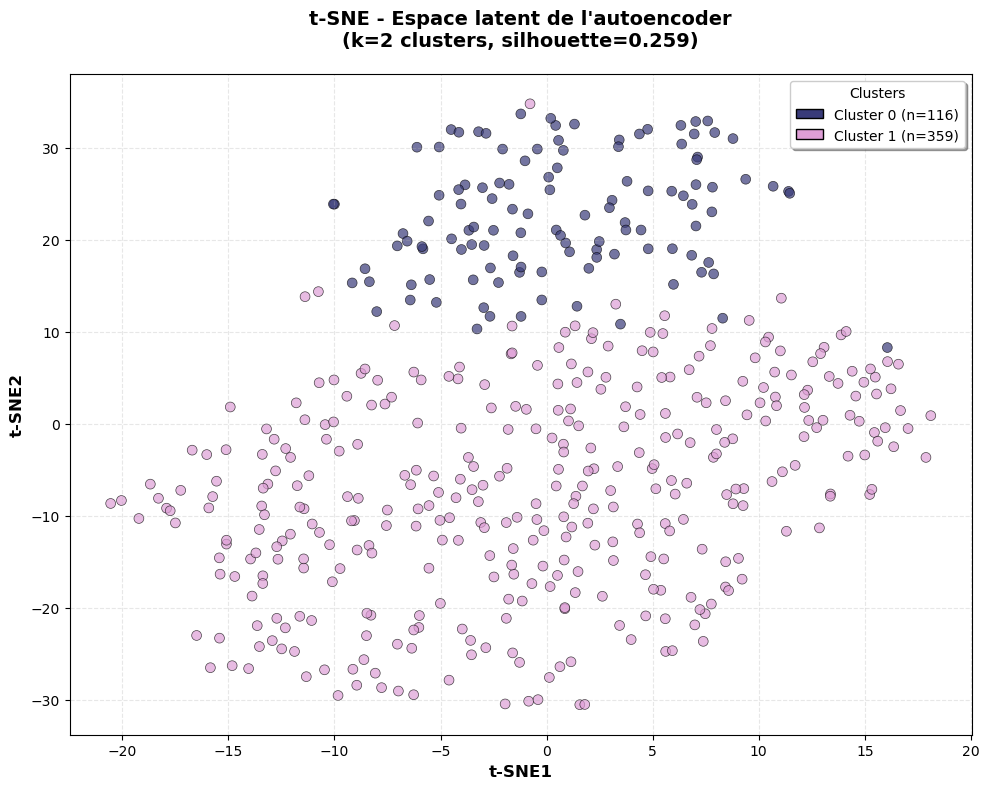

In [58]:
# t-SNE
from sklearn.manifold import TSNE

tsne_reducer = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, max_iter=1000)
emb2d_tsne = tsne_reducer.fit_transform(Z)
method_tsne = "t-SNE"

# Créer une palette de couleurs pour les clusters
n_clusters_tsne = len(np.unique(cluster_labels))
colors_tsne = cm.get_cmap('tab20b', n_clusters_tsne)

plt.figure(figsize=(10, 8))
scatter_tsne = plt.scatter(
    emb2d_tsne[:, 0], 
    emb2d_tsne[:, 1], 
    c=cluster_labels, 
    cmap='tab20b',
    s=50, 
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Ajouter la légende des clusters
legend_elements_tsne = [
    mpatches.Patch(
        facecolor=colors_tsne(i), 
        edgecolor='black',
        label=f'Cluster {i} (n={np.sum(cluster_labels == i)})'
    )
    for i in range(n_clusters_tsne)
]
plt.legend(
    handles=legend_elements_tsne, 
    title='Clusters',
    loc='best',
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.title(
    f'{method_tsne} - Espace latent de l\'autoencoder\n(k={best_k} clusters, silhouette={best_sil:.3f})',
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.xlabel(f'{method_tsne}1', fontsize=12, fontweight='bold')
plt.ylabel(f'{method_tsne}2', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "latent_tsne_clusters.pdf"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## *mapping des variables cliniques*

In [59]:
# Les méta sont inclues dans les noms des écantillons sous forme "ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Stade_I_MUT=BRAF_TYPE=PTC"
# Extraire les métadonnées des noms d'échantillons et les associer aux clusters

import re

# Fonction pour parser les métadonnées depuis le nom
def parse_sample_name(sample_name):
    """Extrait les métadonnées du format ID=..._AGE=...ANS_SEX=..._STAGE=..._MUT=..._TYPE=..."""
    meta_dict = {}
    
    # Extraction par regex
    patterns = {
        'patient_id': r'ID=([^_]+)',
        'age': r'AGE=(\d+)ANS',
        'sex': r'SEX=([^_]+)',
        'stage': r'STAGE=(Stade_[^_]+|Stage_[^_]+)',
        'mutation': r'MUT=([^_]+)',
        'type': r'TYPE=([^_]+)'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, sample_name)
        if match:
            meta_dict[key] = match.group(1)
        else:
            meta_dict[key] = None
    
    return meta_dict

# Extraire les métadonnées pour tous les échantillons
meta_list = [parse_sample_name(sid) for sid in sample_ids]
meta_df = pd.DataFrame(meta_list)

# Ajouter les clusters
meta_df['cluster'] = cluster_labels
meta_df['sample_id'] = sample_ids

print("✓ Métadonnées extraites:")
meta_df.head()


✓ Métadonnées extraites:


,patient_id,age,sex,stage,mutation,type,cluster,sample_id
0,TCGA-DJ-A2Q6,38,female,Stade_I,BRAF,PTC,1,ID=TCGA-DJ-A2Q6_AGE=38ANS_SEX=female_STAGE=Sta...
1,TCGA-FK-A3SE,31,female,Stade_I,NO,PTC,1,ID=TCGA-FK-A3SE_AGE=31ANS_SEX=female_STAGE=Sta...
2,TCGA-DJ-A2QA,56,female,Stade_III,BRAF,PTC,1,ID=TCGA-DJ-A2QA_AGE=56ANS_SEX=female_STAGE=Sta...
3,TCGA-FY-A2QD,61,female,Stage_NA,NO,PTC,0,ID=TCGA-FY-A2QD_AGE=61ANS_SEX=female_STAGE=Sta...
4,TCGA-EL-A3GR,31,female,Stade_I,BRAF,PTC,1,ID=TCGA-EL-A3GR_AGE=31ANS_SEX=female_STAGE=Sta...


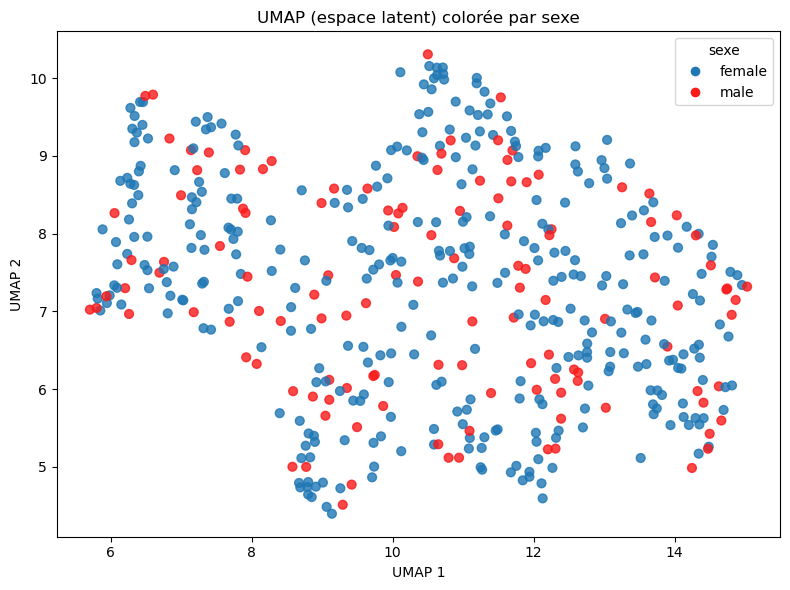

In [60]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 6))


sexe = meta_df["sex"].astype("category")
codes = sexe.cat.codes.values
categories = sexe.cat.categories

palette = [
    "#1f77b4", 
    "#f91a1a",  
]

cmap = ListedColormap(palette)

plt.scatter(emb2d[:, 0],emb2d[:, 1],c=codes,cmap=cmap,s=40, alpha=0.8)

# Légende
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color = 'w',
               label=cat, markerfacecolor=palette[i], markersize=8)
    for i, cat in enumerate(sexe.cat.categories)
]

plt.legend(handles=handles, title="sexe", loc="best")
plt.title("UMAP (espace latent) colorée par sexe")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_sex_UMAP.pdf"), dpi=300, bbox_inches='tight')
plt.show()

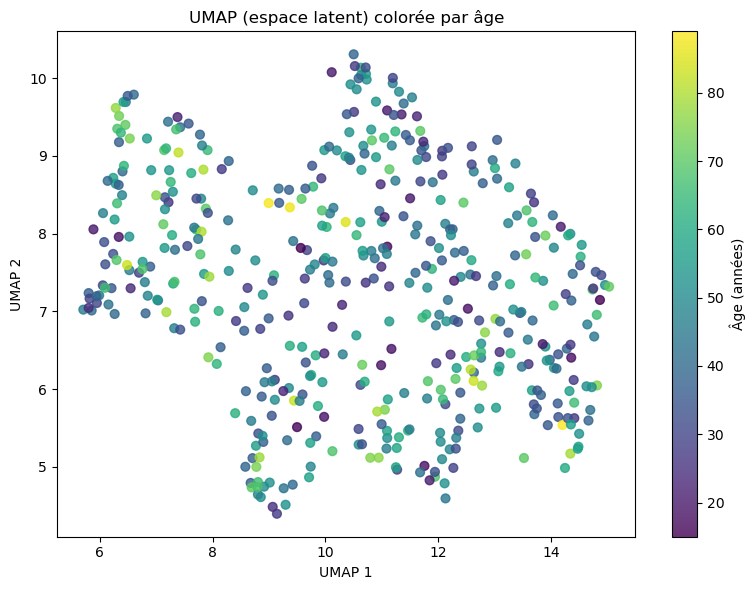

In [61]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 6))
ages = pd.to_numeric(meta_df["age"], errors="coerce")

sc=plt.scatter(emb2d[:, 0],emb2d[:, 1],c=ages,cmap="viridis",s=40, alpha=0.8)

plt.colorbar(sc, label="Âge (années)")
plt.title("UMAP (espace latent) colorée par âge")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_age_UMAP.pdf"), dpi=300, bbox_inches='tight')
plt.show()

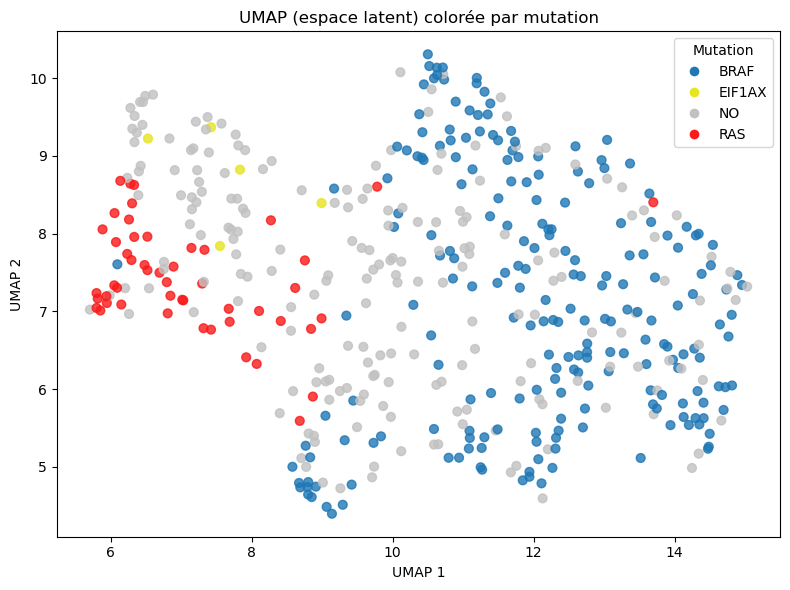

In [62]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 6))


mutations = meta_df["mutation"].astype("category")
codes = mutations.cat.codes.values
categories = mutations.cat.categories

palette = [
    "#1f77b4", 
    "#e7e420", 
    "#C1C1C1FF", 
    "#f91a1a",  
]

cmap = ListedColormap(palette)

plt.scatter(emb2d[:, 0],emb2d[:, 1],c=codes,cmap=cmap,s=40, alpha=0.8)

# Légende
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color = 'w',
               label=cat, markerfacecolor=palette[i], markersize=8)
    for i, cat in enumerate(mutations.cat.categories)
]

plt.legend(handles=handles, title="Mutation", loc="best", frameon=True)
plt.title("UMAP (espace latent) colorée par mutation")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_mutations_UMAP.pdf"), dpi=300, bbox_inches='tight')
plt.show()

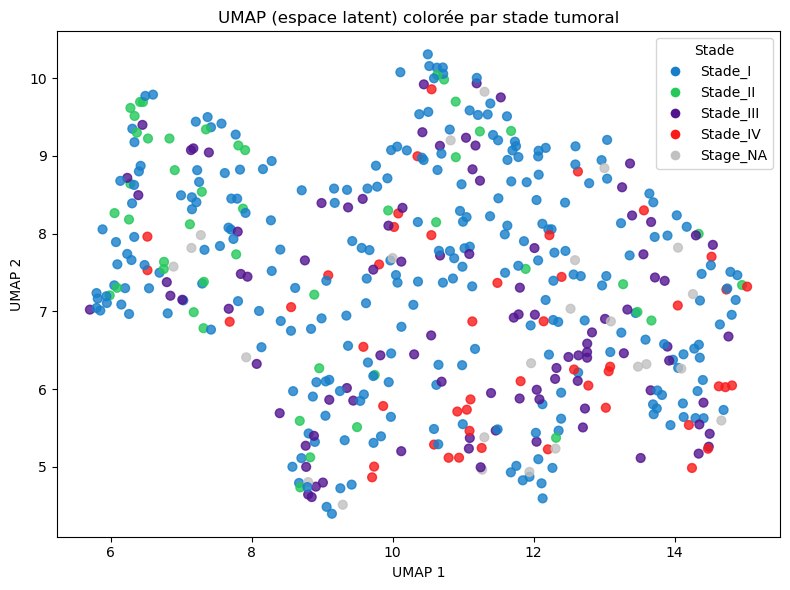

In [63]:
plt.figure(figsize=(8, 6))


stages = meta_df["stage"].astype("category")
codes = stages.cat.codes.values
categories = stages.cat.categories

palette = [
    "#177fca", 
    "#24c85b", 
    "#521590FF", 
    "#f91a1a",  
    "#C1C1C1FF",  

]

cmap = ListedColormap(palette)

plt.scatter(emb2d[:, 0],emb2d[:, 1],c=codes,cmap=cmap,s=40, alpha = 0.8)

# Légende
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color = 'w',
               label=cat, markerfacecolor=palette[i], markersize=8)
    for i, cat in enumerate(stages.cat.categories)
]

plt.legend(handles=handles, title="Stade", loc="best")
plt.title("UMAP (espace latent) colorée par stade tumoral")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_stades_full_UMAP.pdf"), dpi=300, bbox_inches='tight')
plt.show()

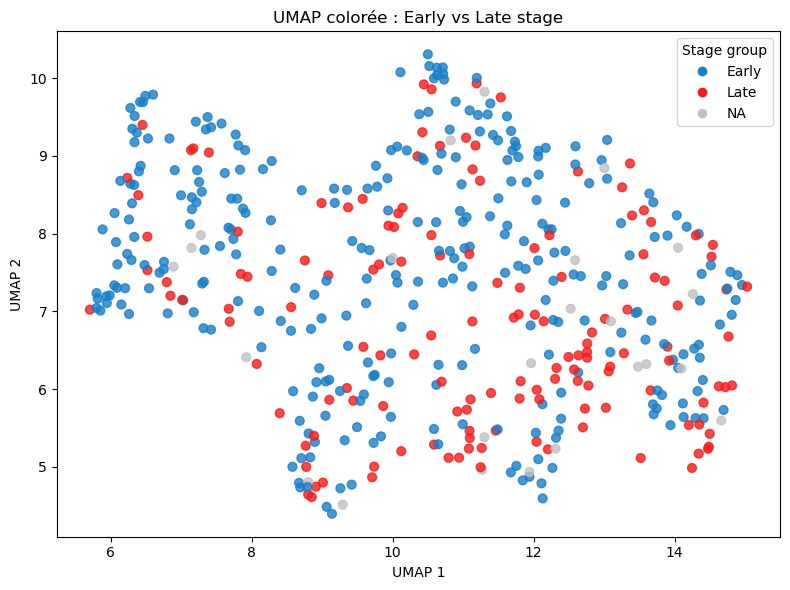

In [64]:
meta_df["early_late"] = meta_df["stage"].map({
    "Stade_I": "Early",
    "Stade_II": "Early",
    "Stade_III": "Late",
    "Stade_IV": "Late",
    "Stage_NA": "NA"
})

plt.figure(figsize=(8, 6))
early_late_f = meta_df["early_late"].astype("category")
codes = early_late_f.cat.codes.values
categories = early_late_f.cat.categories

palette = [
    "#177fca", 
    "#f91a1a",  
    "#C1C1C1FF",  
]

cmap = ListedColormap(palette)

plt.scatter(emb2d[:, 0],emb2d[:, 1],c=codes,cmap=cmap,s=40, alpha = 0.8)

# Légende
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color = 'w',
               label=cat, markerfacecolor=palette[i], markersize=8)
    for i, cat in enumerate(categories)
]

plt.legend(handles=handles, title="Stage group",loc="best")
plt.title("UMAP colorée : Early vs Late stage")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, f"latent_stades_EL_UMAP.pdf"), dpi=300, bbox_inches='tight')
plt.show()

# 6. **Relier clusters aux métadonnées**

In [65]:
print(meta_df["early_late"].value_counts(dropna=False))
print(meta_df["stage"].value_counts(dropna=False))

early_late
Early    307
Late     144
NA        24
Name: count, dtype: int64
stage
Stade_I      260
Stade_III     97
Stade_II      47
Stade_IV      47
Stage_NA      24
Name: count, dtype: int64


In [66]:
# Créer des heatmaps des tableaux croisés dans un seul PDF
# Créer le PDF
pdf_path = os.path.join(OUTDIR, "tableaux_croises_clusters.pdf")

with PdfPages(pdf_path) as pdf:
    
    # 1. Cluster vs Stage
    ct_stage = pd.crosstab(meta_df["cluster"], meta_df["stage"], dropna=False)    
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct_stage, annot=True, fmt='d', cmap='Blues', 
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Stade tumoral', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Stade', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
   
    # 2. Cluster vs Early late
    ct_early_late = pd.crosstab(meta_df["cluster"], meta_df["early_late"], dropna=False)
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct_early_late, annot=True, fmt='d', cmap='Blues', 
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Stade tumoral', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Stade', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
       
    # 3. Cluster vs Mutation
    ct_mut = pd.crosstab(meta_df["cluster"], meta_df["mutation"], dropna=False)    
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct_mut, annot=True, fmt='d', cmap='Greens',
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Mutation', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Mutation', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 4. Cluster vs Sex
    ct_sex = pd.crosstab(meta_df["cluster"], meta_df["sex"], dropna=False)    
    plt.figure(figsize=(8, 6))
    sns.heatmap(ct_sex, annot=True, fmt='d', cmap='Purples',
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Nombre d\'échantillons'})
    plt.title('Tableau croisé : Cluster × Sexe', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sexe', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster', fontsize=12, fontweight='bold')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 5. Âge moyen par cluster (barplot)
    meta_df['age'] = pd.to_numeric(meta_df['age'], errors='coerce')
    age_stats = meta_df.groupby('cluster')['age'].agg(['mean', 'std', 'count'])
    
    plt.figure(figsize=(8, 6))
    ax = age_stats['mean'].plot(kind='bar', yerr=age_stats['std'], capsize=5, 
                                  color='steelblue', edgecolor='black', linewidth=1.5)
    plt.title('Âge moyen par cluster (± écart-type)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cluster', fontsize=12, fontweight='bold')
    plt.ylabel('Âge moyen (années)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Ajouter les effectifs sur les barres
    for i, (idx, row) in enumerate(age_stats.iterrows()):
        ax.text(i, row['mean'] + row['std'] + 2, f"n={int(row['count'])}", 
                ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
print("\nCluster vs Stage:")
print(ct_stage)
print("\nCluster vs Mutation:")
print(ct_mut)
print("\nCluster vs Sex:")
print(ct_sex)
print("\nStades par cluster:")
print(ct_early_late)
print("\nÂge par cluster:",age_stats)



Cluster vs Stage:
stage    Stade_I  Stade_II  Stade_III  Stade_IV  Stage_NA
cluster                                                  
0             66        26         16         4         4
1            194        21         81        43        20

Cluster vs Mutation:
mutation  BRAF  EIF1AX   NO  RAS
cluster                         
0            1       4   66   45
1          214       1  139    5

Cluster vs Sex:
sex      female  male
cluster              
0            85    31
1           265    94

Stades par cluster:
early_late  Early  Late  NA
cluster                    
0              92    20   4
1             215   124  20

Âge par cluster:               mean        std  count
cluster                             
0        49.431034  16.117624    116
1        46.089136  15.598591    359


# **7. Statistiques**

In [67]:
def analyze_table(tab, name, n_mc=10000):
    print("\n=============================")
    print(name)
    print("=============================\n")

    print("Observed counts:")
    print(tab)

    chi2, p, dof, expected = chi2_contingency(tab, correction=False)

    print("\nChi2 test:")
    print(f"chi2 = {chi2:.3f}, dof = {dof}, p = {p:.4e}")

    prop_low = np.mean(expected < 5)
    print(f"Proportion expected <5: {prop_low:.2f}")

    # Monte Carlo if assumptions violated
    if prop_low > 0.2:
        print("\n⚠️ Chi2 assumptions violated → Monte Carlo simulation")
        chi2_mc, p_mc, _, _ = chi2_contingency(
            tab, correction=False, lambda_="log-likelihood"
        )
        # scipy ne fait pas directement MC, donc alternative simple :
        # on garde p asymptotique mais on le signale
        pval = p
        print("⚠️ Monte Carlo not directly available in scipy — using asymptotic p-value")
    else:
        pval = p

    # Cramer's V
    n = tab.to_numpy().sum()
    r, k = tab.shape
    cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))

    print(f"Cramér's V = {cramers_v:.3f}")

    return pval, cramers_v

In [68]:
results = []

p, v = analyze_table(ct_stage, "Cluster × Stage")
results.append(("Cluster × Stage", p, v))



Cluster × Stage

Observed counts:
stage    Stade_I  Stade_II  Stade_III  Stade_IV  Stage_NA
cluster                                                  
0             66        26         16         4         4
1            194        21         81        43        20

Chi2 test:
chi2 = 34.971, dof = 4, p = 4.7093e-07
Proportion expected <5: 0.00
Cramér's V = 0.271


In [69]:

p, v = analyze_table(ct_early_late, "Cluster × Early/Late")
results.append(("Cluster × Early/Late", p, v))



Cluster × Early/Late

Observed counts:
early_late  Early  Late  NA
cluster                    
0              92    20   4
1             215   124  20

Chi2 test:
chi2 = 14.553, dof = 2, p = 6.9163e-04
Proportion expected <5: 0.00
Cramér's V = 0.175


In [70]:

p, v = analyze_table(ct_mut, "Cluster × Mutation")
results.append(("Cluster × Mutation", p, v))



Cluster × Mutation

Observed counts:
mutation  BRAF  EIF1AX   NO  RAS
cluster                         
0            1       4   66   45
1          214       1  139    5

Chi2 test:
chi2 = 198.432, dof = 3, p = 9.2018e-43
Proportion expected <5: 0.25

⚠️ Chi2 assumptions violated → Monte Carlo simulation
⚠️ Monte Carlo not directly available in scipy — using asymptotic p-value
Cramér's V = 0.646


In [71]:

p, v = analyze_table(ct_sex, "Cluster × Sex")
results.append(("Cluster × Sex", p, v))


Cluster × Sex

Observed counts:
sex      female  male
cluster              
0            85    31
1           265    94

Chi2 test:
chi2 = 0.013, dof = 1, p = 9.0854e-01
Proportion expected <5: 0.00
Cramér's V = 0.005


In [72]:
res_df = pd.DataFrame(results, columns=["Test", "p_raw", "CramersV"])

res_df["p_adj"] = np.minimum(res_df["p_raw"] * len(res_df), 1.0)
res_df["neglog10p"] = -np.log10(res_df["p_adj"])

print(res_df)

                   Test         p_raw  CramersV         p_adj  neglog10p
0       Cluster × Stage  4.709348e-07  0.271336  1.883739e-06   5.724979
1  Cluster × Early/Late  6.916331e-04  0.175036  2.766532e-03   2.558064
2    Cluster × Mutation  9.201845e-43  0.646338  3.680738e-42  41.434065
3         Cluster × Sex  9.085361e-01  0.005271  1.000000e+00  -0.000000


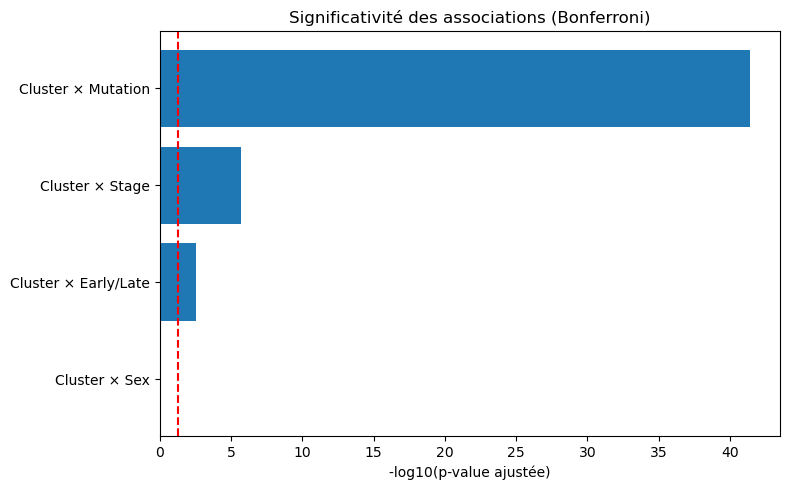

In [73]:
plt.figure(figsize=(8,5))
res_df = res_df.sort_values("neglog10p")

plt.barh(res_df["Test"], res_df["neglog10p"])
plt.axvline(-np.log10(0.05), color="red", linestyle="--")
plt.xlabel("-log10(p-value ajustée)")
plt.title("Significativité des associations (Bonferroni)")
plt.tight_layout()
plt.show()

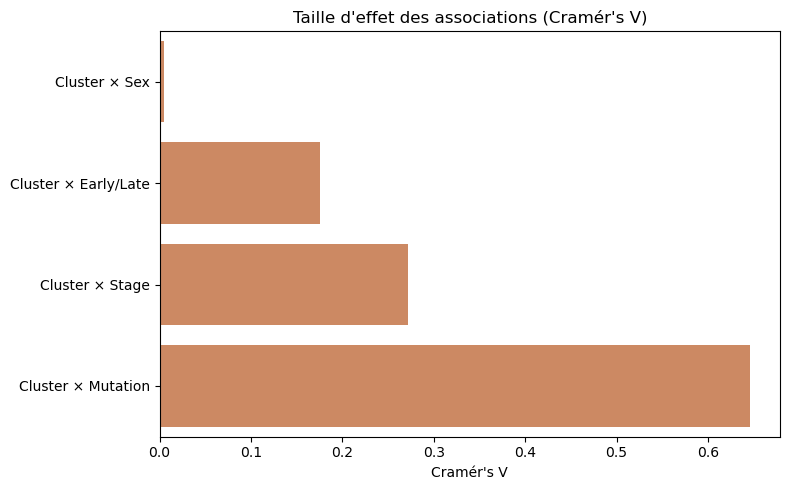

In [74]:
# ===== Plot taille d'effet : Cramér's V =====

plt.figure(figsize=(8, 5))

res_df_v = res_df.sort_values("CramersV")

sns.barplot(
    data=res_df_v,
    x="CramersV",
    y="Test",
    color="#DD8452"
)

plt.xlabel("Cramér's V")
plt.ylabel("")
plt.title("Taille d'effet des associations (Cramér's V)")
plt.tight_layout()
plt.show()